In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
data_path_all = "../artifcats/data/customer_churn.json"
data_path_mini = "../artifcats/data/customer_churn_mini.json"

In [3]:
df_all = pd.read_json(data_path_all, lines=True)
df_mini = pd.read_json(data_path_mini, lines=True)

In [44]:
# Concatenate both dataframes after ensureing they have the same columns
df = pd.concat([df_all, df_mini], ignore_index=True)

### First: understand avaliable atrributes
1. Type of each attribute
2. What should be the range neumiric values, are there any unrelaiable values?

In [5]:
# Get an overview of the datasets, datatypes, non-null counts, memory usage etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830205 entries, 0 to 830204
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             830205 non-null  int64  
 1   userId         830205 non-null  object 
 2   sessionId      830205 non-null  int64  
 3   page           830205 non-null  object 
 4   auth           830205 non-null  object 
 5   method         830205 non-null  object 
 6   status         830205 non-null  int64  
 7   level          830205 non-null  object 
 8   itemInSession  830205 non-null  int64  
 9   location       806159 non-null  object 
 10  userAgent      806159 non-null  object 
 11  lastName       806159 non-null  object 
 12  firstName      806159 non-null  object 
 13  registration   806159 non-null  float64
 14  gender         806159 non-null  object 
 15  artist         660985 non-null  object 
 16  song           660985 non-null  object 
 17  length         660985 non-nul

In [6]:
# Identify numerical and categorical columns to preprocess them differently
neumiric_columns = df.select_dtypes(include=["number"]).columns
categorical_columns = df.select_dtypes(include=["object", "category"]).columns

In [7]:
# Display first few rows of the dataframe to understand its structure and content
df_all.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342


In [8]:
df["status"].unique()  # is numeric but should be converted to categorical

array([200, 307, 404])

In [9]:
# Check unique values in categorical columns
for column in categorical_columns:
    print(f"Unique values in '{column}': {df[column].nunique()}")

Unique values in 'userId': 450
Unique values in 'page': 22
Unique values in 'auth': 4
Unique values in 'method': 2
Unique values in 'level': 2
Unique values in 'location': 193
Unique values in 'userAgent': 71
Unique values in 'lastName': 279
Unique values in 'firstName': 347
Unique values in 'gender': 2
Unique values in 'artist': 22515
Unique values in 'song': 88223


In [10]:
# These columns have limited unique values, thus should unserstand the possible values
cols = ["auth", "method", "level", "page"]
for col in cols:
    print(f"\nUnique values in '{col}': {df[col].unique()}")


Unique values in 'auth': ['Logged In' 'Logged Out' 'Cancelled' 'Guest']

Unique values in 'method': ['PUT' 'GET']

Unique values in 'level': ['free' 'paid']

Unique values in 'page': ['NextSong' 'Logout' 'Home' 'Login' 'Downgrade' 'Add to Playlist'
 'Roll Advert' 'Thumbs Up' 'Help' 'Thumbs Down' 'Add Friend' 'About'
 'Settings' 'Save Settings' 'Upgrade' 'Submit Downgrade' 'Cancel'
 'Cancellation Confirmation' 'Submit Upgrade' 'Error' 'Register'
 'Submit Registration']


#### Time features:
1. `ts`: timestamp of the log.
2. `registration` when the user registered in the service. 


#### User information 
3. `userID`: identify each user, we have records for 450 users (before cleaning)
4. `gender`: male or female [F, M].
5. `lastName`: user last name.
6. `firstName`: user first name.
7. `auth`: ['Logged In' 'Logged Out' 'Cancelled': canceled the authentication 'Guest'].
8. `level`: user plan ['free' 'paid'].
9. `userAgent`: user device and browser.
10. `location` request location.

#### Interaction information:
11. `sessionId`: which session the timestamp belongs to.
12. `itemInSession`: event order in session, each interaction recorded as event.
13. `page`: page user do the request when the log captured, we have 22 possible values for page:
    ['NextSong' 'Logout' 'Home'
     'Login' 'Downgrade' 'Add to Playlist'
    'Roll Advert' 'Thumbs Up' 'Help' 'Thumbs Down' 
    'Add Friend' 'About' 'Settings' 'Save Settings' 
    'Upgrade' 'Submit Downgrade' 'Cancel'
    'Cancellation Confirmation' 'Submit Upgrade' 
    'Error' 'Register' 'Submit Registration']
14. `method`: request method ['PUT' 'GET'].
15. `status`: response status code {"200" :"OK", "307": "Temporary Redirect", "404": "Not Found"}

#### Content Info:
16. `artist`: song performer 
17. `song`: song title
18. `length`: song duration

==============


**We will study each group sepratly**

In [11]:
cols = df.columns.tolist()
time_cols = ["ts", "registration"]
content_cols = ["artist", "song", "length"]
interaction_cols = [
    "sessionId",
    "itemInSession",
    "page",
    "method",
    "status",
]
user_info_cols = [
    "userId",
    "gender",
    "location",
    "level",
    "auth",
    "userAgent",
    "lastName",
    "firstName",
]

### Seconds: do we have any problem withen the data?
1. Handle null and missing values and duplicates.
2. Resolve outliers.

#### 1. Handle null and missing values and duplicates.

In [12]:
df.isnull().sum()

ts                    0
userId                0
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          24046
userAgent         24046
lastName          24046
firstName         24046
registration      24046
gender            24046
artist           169220
song             169220
length           169220
dtype: int64

In [13]:
# There is a pattren in the missing values, mostly in the content columns, which is expected as not all user interactions involve a song (e.g., login, logout, etc.)
df[df["artist"].isna()]["page"].value_counts()

page
Home                         41869
Thumbs Up                    36377
Add to Playlist              18875
Add Friend                   12364
Roll Advert                  11706
Login                         9252
Logout                        9216
Thumbs Down                   7457
Downgrade                     5866
Help                          4876
Settings                      4478
About                         2779
Upgrade                       1467
Save Settings                  895
Error                          777
Submit Upgrade                 446
Submit Downgrade               180
Cancellation Confirmation      151
Cancel                         151
Register                        29
Submit Registration              9
Name: count, dtype: int64

In [14]:
# We can see a pattren in the missing values of user information columns, mostly in `firstName` and `lastName` columns. We need to understand the reason behind this pattern.
df[df["firstName"].isna()]["auth"].value_counts()
# The user is not logged in so we don't have their information and null values in these columns are expected.

auth
Logged Out    23855
Guest           191
Name: count, dtype: int64

Remove rows with empty user_info columns, as it represent only 2.90% of the dataset, and is out of the chron detection scope. and even if we try to fill it `registration` columns contains sensitive info that is difficult to fill randomly.

In [45]:
user_info_cols = [
    "location",
    "userAgent",
    "lastName",
    "firstName",
    "registration",
    "gender",
]
df = df.dropna(subset=user_info_cols)

In [46]:
df.isnull().sum()

ts                    0
userId                0
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location              0
userAgent             0
lastName              0
firstName             0
registration          0
gender                0
artist           145174
song             145174
length           145174
dtype: int64

In [47]:
df["length"].fillna(
    0, inplace=True
)  # fill missing length with 0 as these are not song related interactions
df["artist"].fillna("Unknown", inplace=True)  # fill missing artist with 'Unknown'
df["song"].fillna("Unknown", inplace=True)  # fill missing song with 'Unknown

/tmp/ipykernel_1888/212756216.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['length'].fillna(0, inplace=True) # fill missing length with 0 as these are not song related interactions
/tmp/ipykernel_1888/212756216.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [48]:
df.isnull().sum()

ts               0
userId           0
sessionId        0
page             0
auth             0
method           0
status           0
level            0
itemInSession    0
location         0
userAgent        0
lastName         0
firstName        0
registration     0
gender           0
artist           0
song             0
length           0
dtype: int64

### Decicion:
- Remaining missing values are natural, so we need to make a flag that explain this situation and use a model that works well with null values (missing values) like XGBoost & LightGBM if we used them in the training at all.

In [19]:
df["song_played"] = df["artist"].notna().astype(int)

In [20]:
# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 98


In [49]:
# Remove duplicate rows as they are too small in number (<0.01% of the dataset)
df = df.drop_duplicates()

#### 2. Resolve outliers

In [22]:
# Explore numierical columns, we select the `itemInSession` becaues other columns are either ids or timestamps
df["itemInSession"].describe()
# we can see there is outliers in the data, max is 1321 while mean is 109.76 and 75% percentile is 150. Thus we need to treat this column carefully during modeling.

count    806061.000000
mean        110.249118
std         121.551070
min           0.000000
25%          27.000000
50%          69.000000
75%         151.000000
max        1321.000000
Name: itemInSession, dtype: float64

In [23]:
df["length"].describe()

count    806061.000000
mean        204.022279
std         130.872497
min           0.000000
25%         157.256690
50%         219.924440
75%         265.377510
max        3024.665670
Name: length, dtype: float64

In [24]:
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]
    return outliers

In [25]:
items = find_outliers_iqr(df, "itemInSession")
length = find_outliers_iqr(df, "length")

<Axes: xlabel='level', ylabel='count'>

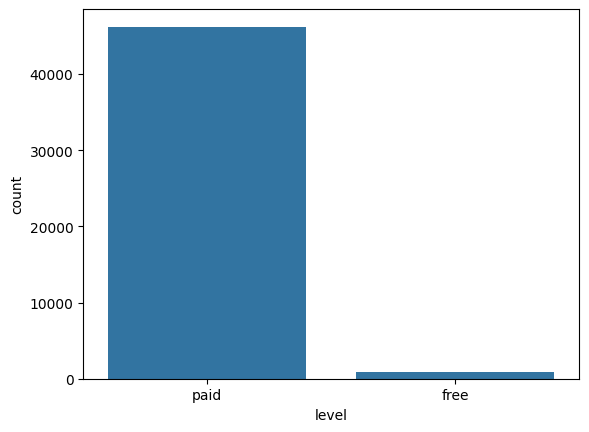

In [26]:
sns.countplot(data=items, x="level")

<Axes: xlabel='level', ylabel='count'>

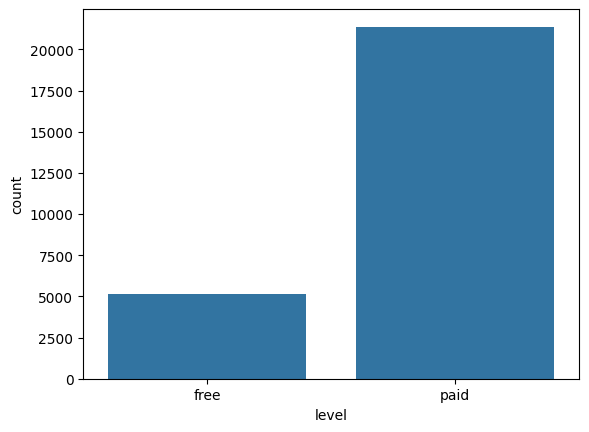

In [27]:
sns.countplot(data=length, x="level")

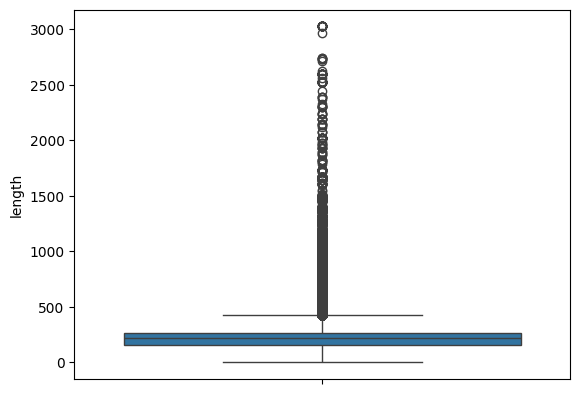

In [28]:
sns.boxplot(data=df, y=df["length"])
plt.show()

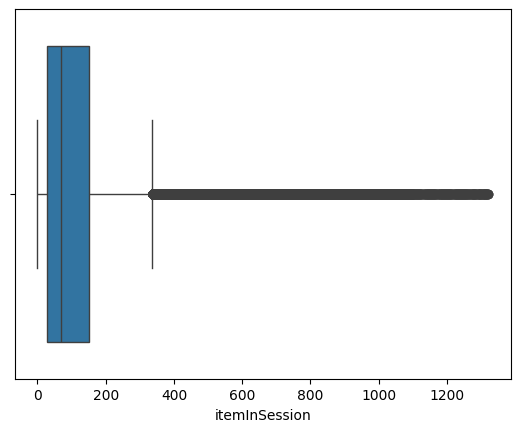

In [29]:
sns.boxplot(data=df, x=df["itemInSession"])
plt.show()

As we can see, there is no outliers. as it's a natural behaviour from paid users to spent more hours, and this will not affect the algorithim as points are close from each other.

### Third: Define the target variable:
1. Define Target Variable
2. Summuraize features for each userID. 
1. Check for correlation between features and with the target variable.
2. Identify features distribution and normalize them.
3. Identify feature importance and reduce dimintionality.

In [50]:
df_test = df.sort_values(["userId", "ts"])

In [51]:
df_test

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
36392,1538965220000,10,9,NextSong,Logged In,PUT,200,paid,0,"Laurel, MS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Bradley,Brycen,1.538159e+12,M,Sea Wolf,Ses Monuments,265.53424
36393,1538965243000,10,9,Home,Logged In,GET,200,paid,1,"Laurel, MS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Bradley,Brycen,1.538159e+12,M,Unknown,Unknown,0.00000
36402,1538965485000,10,9,NextSong,Logged In,PUT,200,paid,2,"Laurel, MS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Bradley,Brycen,1.538159e+12,M,Angus & Julia Stone,Big Jet Plane,239.12444
564629,1538965485000,10,9,NextSong,Logged In,PUT,200,paid,1,"Laurel, MS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Bradley,Brycen,1.538159e+12,M,George Baker Selection,Morning Sky,200.43710
564631,1538965685000,10,9,NextSong,Logged In,PUT,200,paid,2,"Laurel, MS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Bradley,Brycen,1.538159e+12,M,Klaus Lage,Du Hast'n Freund In Mir (You've Got A Friend I...,208.03873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381561,1543345330000,99,3206,NextSong,Logged In,PUT,200,free,30,"New Haven-Milford, CT","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Atkinson,Madison,1.531812e+12,F,BarlowGirl,No One Like You (LP Version),193.38404
381562,1543345331000,99,3206,Roll Advert,Logged In,GET,200,free,31,"New Haven-Milford, CT","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Atkinson,Madison,1.531812e+12,F,Unknown,Unknown,0.00000
381578,1543345523000,99,3206,NextSong,Logged In,PUT,200,free,32,"New Haven-Milford, CT","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Atkinson,Madison,1.531812e+12,F,Los Amigos Invisibles,Sexy,203.96363
381587,1543345726000,99,3206,NextSong,Logged In,PUT,200,free,33,"New Haven-Milford, CT","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Atkinson,Madison,1.531812e+12,F,D'Angelo,Devil's Pie (Explicit),321.64526


### Split the data before any further processing to ensure data is not leaked

In [ ]:

df["ts"] = pd.to_datetime(df["ts"], unit="ms")

last_seen = df.groupby("userId")["ts"].max().reset_index()
last_seen = last_seen.sort_values("ts")

test_ratio = 0.2
cutoff = int(len(last_seen) * (1 - test_ratio))

train_users = last_seen.iloc[:cutoff]["userId"]
test_users = last_seen.iloc[cutoff:]["userId"]

train_df = df[df["userId"].isin(train_users)].reset_index(drop=True)
test_df = df[df["userId"].isin(test_users)].reset_index(drop=True)

In [58]:
train_df.to_json("../artifacts/data/train_data.json", lines=True, orient="records")
test_df.to_json("../artifacts/data/test_data.json", lines=True, orient="records")

### Remaining parts are just exploration to prepare the modules

In [ ]:
data = (
    df_test.groupby("userId")
    .agg(
        first_name=("firstName", "first"),
        last_name=("lastName", "first"),
        gender=("gender", "first"),
        registration=("registration", "first"),
        location=("location", "last"),
        user_agent=("userAgent", "first"),
        initial_level=("level", "first"),
        final_level=("level", "last"),
        total_sessions=("sessionId", "nunique"),
        total_logs=("ts", "count"),
        total_errors=("status", lambda x: (x >= 400).sum()),
        like_count=("page", lambda x: (x == "Thumbs Up").sum()),
        dislike_count=("page", lambda x: (x == "Thumbs Down").sum()),
        artists_played=("artist", lambda x: x[x != "Unknown"].nunique()),
        songs_played=("song", lambda x: x[x != "Unknown"].nunique()),
        avg_listen_time=("length", "mean"),
        label=(
            "page",
            lambda x: x.isin(["Cancellation Confirmation"]).any().astype(int),
        ),
    )
    .reset_index()
)

In [65]:
test_df["label"].value_counts()

label
0    70
1    20
Name: count, dtype: int64

In [62]:
train_df.head()

,userId,first_name,last_name,gender,registration,location,user_agent,initial_level,final_level,total_sessions,total_logs,total_errors,like_count,dislike_count,artists_played,songs_played,avg_listen_time,label
0,10,Brycen,Bradley,M,1.538159e+12,"Laurel, MS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",paid,paid,6,1217,1,54,5,802,945,211.277961,1
1,100001,Delaney,Perez,F,1.534627e+12,"Miami-Fort Lauderdale-West Palm Beach, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",free,free,6,320,1,13,3,213,222,183.965880,1
2,100003,Nevaeh,Jones,F,1.537309e+12,"Miami-Fort Lauderdale-West Palm Beach, FL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,free,paid,10,904,1,19,10,584,672,192.926095,1
3,100004,Emily,Fisher,F,1.528560e+12,"Syracuse, NY",Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,free,paid,24,1617,3,50,13,896,1119,183.514406,1
4,100005,Cason,Smith,M,1.532611e+12,"Monroe, LA","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",free,free,6,315,0,9,4,213,225,172.668897,1


In [34]:
import re

# map states to regions
state_to_region = {
    # Northeast
    "CT": "Northeast",
    "ME": "Northeast",
    "MA": "Northeast",
    "NH": "Northeast",
    "RI": "Northeast",
    "VT": "Northeast",
    "NJ": "Northeast",
    "NY": "Northeast",
    "PA": "Northeast",
    # Midwest
    "IL": "Midwest",
    "IN": "Midwest",
    "MI": "Midwest",
    "OH": "Midwest",
    "WI": "Midwest",
    "IA": "Midwest",
    "KS": "Midwest",
    "MN": "Midwest",
    "MO": "Midwest",
    "NE": "Midwest",
    "ND": "Midwest",
    "SD": "Midwest",
    # South
    "DE": "South",
    "FL": "South",
    "GA": "South",
    "MD": "South",
    "NC": "South",
    "SC": "South",
    "VA": "South",
    "DC": "South",
    "WV": "South",
    "AL": "South",
    "KY": "South",
    "MS": "South",
    "TN": "South",
    "AR": "South",
    "LA": "South",
    "OK": "South",
    "TX": "South",
    # West
    "AZ": "West",
    "CO": "West",
    "ID": "West",
    "MT": "West",
    "NV": "West",
    "NM": "West",
    "UT": "West",
    "WY": "West",
    "AK": "West",
    "CA": "West",
    "HI": "West",
    "OR": "West",
    "WA": "West",
}


# استخراج رمز الولاية من النص
def extract_state(location):
    match = re.search(r", ([A-Z]{2})", location)
    if match:
        return match.group(1)
    return None


data["region"] = data["location"].apply(extract_state).map(state_to_region)

In [35]:
def simplify_user_agent(ua):
    ua = ua.lower()
    if "edg" in ua:  # Edge
        return "Edge"
    elif "msie" in ua or "trident" in ua:  # Internet Explorer
        return "Internet Explorer"
    elif "firefox" in ua:
        return "Firefox"
    elif "chrome" in ua or "crios" in ua or "chromium" in ua:
        return "Chrome"
    elif "safari" in ua:
        return "Safari"
    else:
        return "Other"


data["userAagent"] = data["user_agent"].apply(simplify_user_agent)

In [36]:
data["userAagent"].value_counts()

userAagent
Chrome               229
Firefox               99
Safari                89
Internet Explorer     32
Name: count, dtype: int64

In [37]:
data.drop(columns=["first_name", "last_name", "user_agent", "location"], inplace=True)

In [38]:
data["like_ratio"] = data["like_count"] / (
    data["like_count"] + data["dislike_count"] + 1e-5
)
data.drop(
    columns=[
        "songs_played",
        "total_logs",
        "like_count",
        "dislike_count",
        "artists_played",
    ],
    inplace=True,
)

In [39]:
data

,userId,gender,registration,initial_level,final_level,total_sessions,total_errors,avg_listen_time,label,region,userAagent,like_ratio
0,10,M,1.538159e+12,paid,paid,6,1,211.277961,1,South,Chrome,0.915254
1,100,M,1.537982e+12,free,paid,74,6,208.321945,0,South,Firefox,0.819718
2,100001,F,1.534627e+12,free,free,6,1,183.965880,1,South,Chrome,0.812499
3,100002,F,1.529935e+12,paid,paid,8,0,218.554378,0,West,Firefox,0.866666
4,100003,F,1.537309e+12,free,paid,10,1,192.926095,1,South,Firefox,0.655172
...,...,...,...,...,...,...,...,...,...,...,...,...
444,95,F,1.538212e+12,paid,free,64,7,207.810946,0,West,Firefox,0.822394
445,96,F,1.537150e+12,paid,paid,36,3,210.031098,0,Northeast,Chrome,0.794392
446,97,F,1.536020e+12,free,paid,56,3,199.580587,0,West,Chrome,0.886598
447,98,M,1.538070e+12,free,paid,57,10,210.559954,0,South,Chrome,0.822742


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userId           449 non-null    object 
 1   gender           449 non-null    object 
 2   registration     449 non-null    float64
 3   initial_level    449 non-null    object 
 4   final_level      449 non-null    object 
 5   total_sessions   449 non-null    int64  
 6   total_errors     449 non-null    int64  
 7   avg_listen_time  449 non-null    float64
 8   label            449 non-null    int64  
 9   region           449 non-null    object 
 10  userAagent       449 non-null    object 
 11  like_ratio       449 non-null    float64
dtypes: float64(3), int64(3), object(6)
memory usage: 42.2+ KB


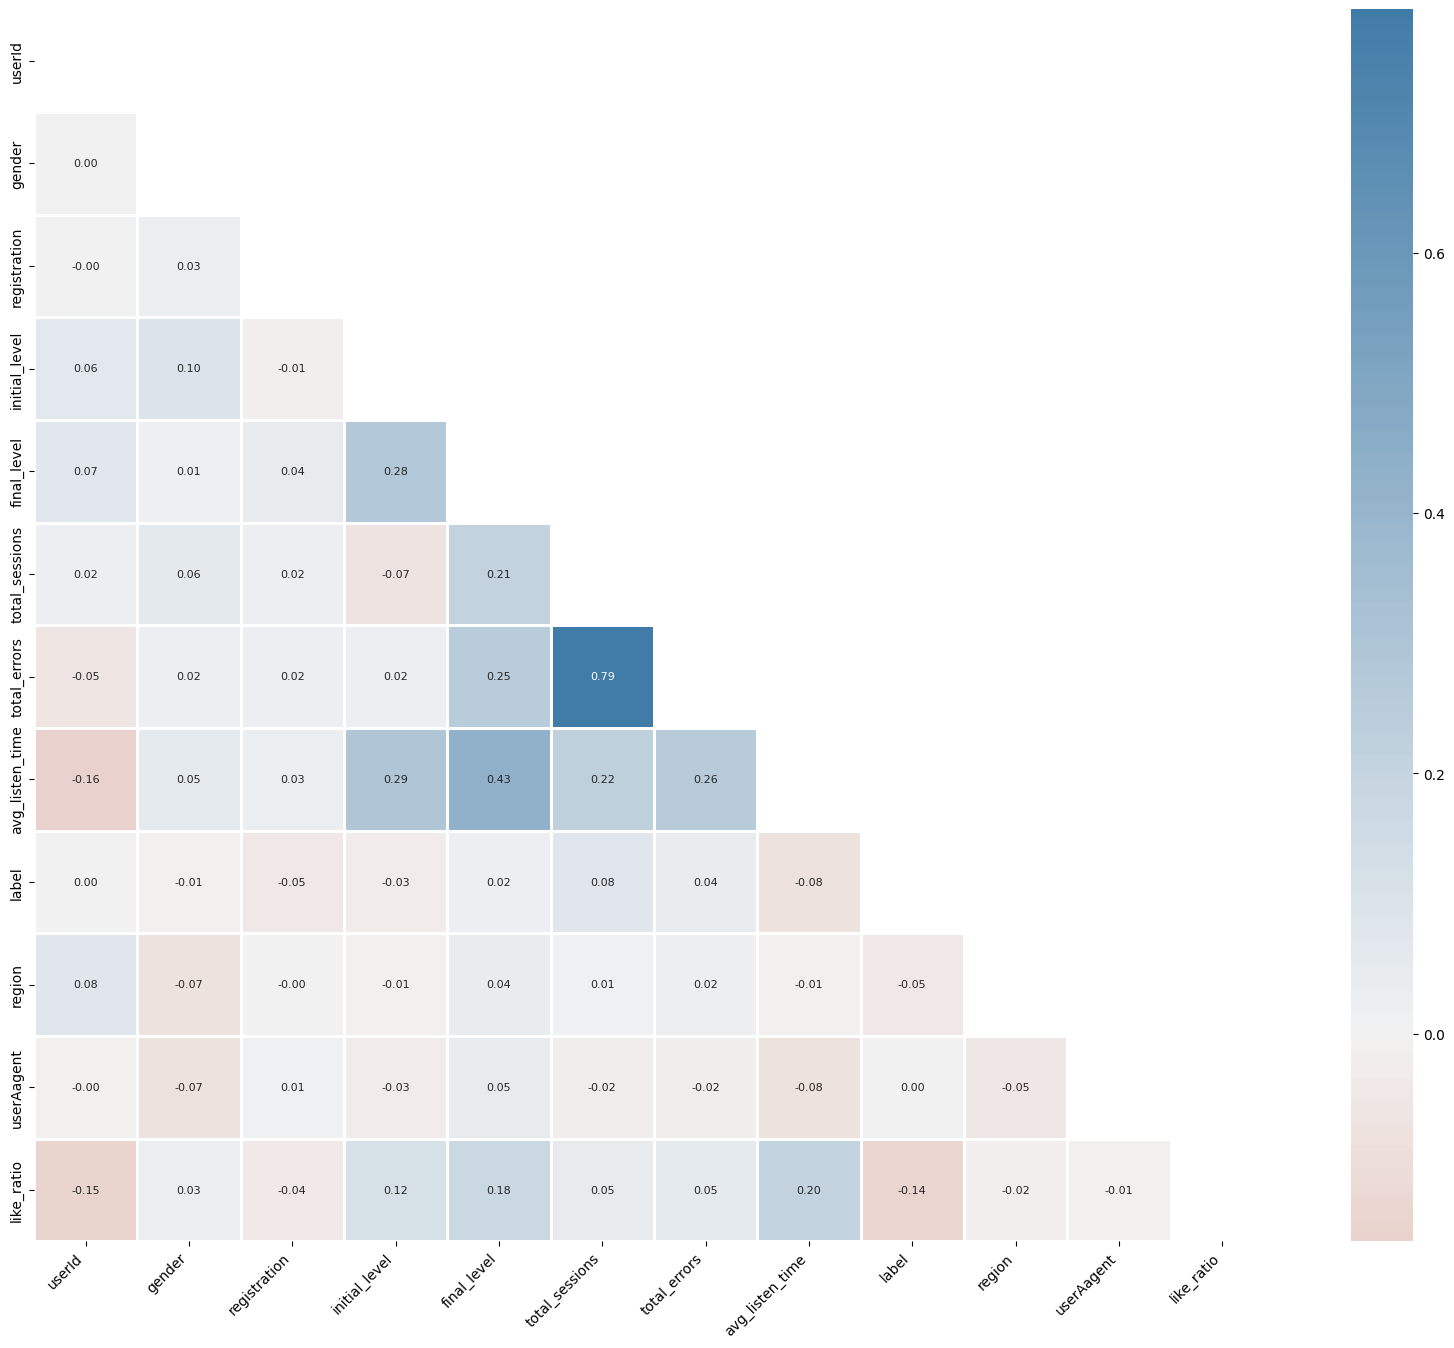

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a diverging colormap
cmap = sns.diverging_palette(h_neg=20, h_pos=240, as_cmap=True)

data["initial_level"] = data["initial_level"].map({"free": 0, "paid": 1})
data["final_level"] = data["final_level"].map({"free": 0, "paid": 1})
data["gender"] = data["gender"].map({"M": 0, "F": 1})
data["region"] = data["region"].map(
    {"Northeast": 0, "Midwest": 1, "South": 2, "West": 3}
)
data["userAagent"] = data["userAagent"].map(
    {
        "Chrome": 0,
        "Firefox": 1,
        "Safari": 2,
        "Edge": 3,
        "Internet Explorer": 4,
        "Other": 5,
    }
)


# Calculate the correlation matrix
corr = data.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Customize the heatmap for better readability
plt.figure(figsize=(20, 16))  # Increase figure size for better visibility
sns.heatmap(
    corr,
    mask=mask,
    center=0,
    cmap=cmap,
    linewidths=1,
    annot=True,
    fmt=".2f",
    annot_kws={"fontsize": 8},
)  # Adjust font size for better readability

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

plt.show()

**We have to removed correlated attributes with corr > 0.90**
